In [1]:
import numpy as np
import os
import lightkurve as lk
import pandas as pd

from astroquery.mast import Catalogs

from leo_vetter.stellar import quadratic_ldc
from leo_vetter.main import TCELightCurve
from leo_vetter.plots import plot_summary_with_diff, plot_diffimages
from leo_vetter.thresholds import check_thresholds
from leo_vetter.pixel import pixel_vetting

from tess_stars2px import tess_stars2px_function_entry as ts2px

### Vetting example for TOI-101.01, including difference images

In the first example, we only computed flux-level metrics, but pixel-level metrics are another key component of false positive identification. Signals that are off-target (coming from another star) are one of the most common types of false positives.

Since difference images are the most time-intensive part of this vetting, it is recommended that you only run pixel-level vetting on signals that pass the flux-level vetting tests.

We'll start with the same steps as the previous example (getting the light curve, setting the TCE properties, etc).

In [2]:
tic = 231663901
per = 1.430363 
epo = 1338.885
dur = 0.069

# Download light curve
search_result = lk.search_lightcurve(f"TIC {tic}", mission="TESS", author="TESS-SPOC")
lcs = search_result.download_all()
lc = lcs.stitch()
lc = lc[~np.isnan(lc["flux"]) & (lc["quality"] == 0)]
transit_mask = lc.create_transit_mask(transit_time=epo, period=per, duration=dur)
lc_flat = lc.flatten(mask=transit_mask)

time = np.asarray(lc_flat["time"].value)
raw = np.asarray(lc["flux"].value)
flux = np.asarray(lc_flat["flux"].value)
flux_err = np.asarray(lc_flat["flux_err"].value)

# Get stellar properties
result = Catalogs.query_criteria(catalog="TIC", ID=tic)
star = {}
star["tic"] = tic
for key in ["rad","mass","rho","Teff","logg"]:
    star[key] = float(result[key])
    star["e_"+key] = float(result["e_"+key])

star["u1"], star["u2"] = quadratic_ldc(star["Teff"], star["logg"])

# Pixel vetting also requires the RA and DEC
star["ra"] = float(result["ra"])
star["dec"] = float(result["dec"])

# Load the TCELightCurve class
tlc = TCELightCurve(tic, time, raw, flux, flux_err, per, epo, dur, planetno=1)

# If you ran the previous notebook, the metrics were saved to a file, so we can skip recomputing them here.
save_file = f"{tlc.tic}.{tlc.planetno}.metrics"

if os.path.exists(save_file):
    print("Loading saved metrics from file.")
    metrics = pd.read_csv(save_file, index_col=False)
    tlc.metrics = metrics.to_dict("records")[0]
else:
    tlc.compute_flux_metrics(star, verbose=False)

/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/leo_vetter/utils.py:17: RuntimeWarning: invalid value encountered in scalar divide
  mean = np.sum(w * y) / np.sum(w)
/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/leo_vetter/utils.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  err = 1 / np.sqrt(np.sum(w))
/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/leo_vetter/individual.py:106: RuntimeWarning: divide by zero encountered in scalar divide
  tlc.redchi2[i] = chi2 / (np.sum(fit_epoch) - 6)


Difference images need to be made for individual sectors. The star has been observed in several sectors, which we can check with `tess-point`:

In [3]:
_, _, _, all_sectors, all_cams, all_ccds, _, _, _ = ts2px(tic, star["ra"], star["dec"])

print(all_sectors, all_cams, all_ccds)

[ 1 27 67 94 95] [2 2 2 2 2] [4 3 3 3 4]


Keep in mind that this will give the list of all sectors that have and *will* been observed in the near future, but we can only make difference images for sectors that have actually been observed. Check [the TESS observations page](https://tess.mit.edu/observations/) if you're not sure which sector TESS is observing yet.

At this time of writing, all five of those sectors have been observed, so let's make difference images for all of them:

In [4]:
sectors = [1, 27, 67, 94, 95]
tdi, good_sectors, good_pixel_data, good_centroids = pixel_vetting(tlc, star, sectors, tdi_dir=".")

curl -JL "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=318.736915161395&dec=-55.8717944482812&y=21&x=21&sector=1" --output ./tic231663901_s1.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 10.9M  100 10.9M    0     0  1597k      0  0:00:06  0:00:06 --:--:-- 3414k


['./tic231663901/tess-s0001-2-4_318.736915_-55.871794_21x21_astrocut.fits']
./tic231663901/tess-s0001-2-4_318.736915_-55.871794_21x21_astrocut.fits
making difference image for sector 1
curl -JL "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=318.736915161395&dec=-55.8717944482812&y=21&x=21&sector=27" --output ./tic231663901_s27.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 28.5M  100 28.5M    0     0  3566k      0  0:00:08  0:00:08 --:--:-- 7092k


['./tic231663901/tess-s0027-2-3_318.736915_-55.871794_21x21_astrocut.fits']
./tic231663901/tess-s0027-2-3_318.736915_-55.871794_21x21_astrocut.fits
making difference image for sector 27
curl -JL "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=318.736915161395&dec=-55.8717944482812&y=21&x=21&sector=67" --output ./tic231663901_s67.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
100 99.3M  100 99.3M    0     0  5145k      0  0:00:19  0:00:19 --:--:-- 7427k


['./tic231663901/tess-s0067-2-3_318.736915_-55.871794_21x21_astrocut.fits']
./tic231663901/tess-s0067-2-3_318.736915_-55.871794_21x21_astrocut.fits
Some cadences have an invalid barycentric correction
making difference image for sector 67


/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/transitDiffImage/tessDiffImage.py:471: RuntimeWarning: Mean of empty slice
  meanInTransit = np.nanmean(pixelData["flux"][inTransitIndices,::-1,:], axis=0)
/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/transitDiffImage/tessDiffImage.py:472: RuntimeWarning: invalid value encountered in divide
  meanInTransitSigma = np.sqrt(np.sum(pixelData["fluxErr"][inTransitIndices,::-1,:]**2, axis=0)/len(inTransitIndices))
/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/transitDiffImage/tessDiffImage.py:473: RuntimeWarning: Mean of empty slice
  meanOutTransit = np.nanmean(pixelData["flux"][outTransitIndices,::-1,:], axis=0)
/Users/batfan/miniconda3/envs/exoplanet/lib/python3.12/site-packages/transitDiffImage/tessDiffImage.py:474: RuntimeWarning: invalid value encountered in divide
  meanOutTransitSigma = np.sqrt(np.sum(pixelData["fluxErr"][outTransitIndices,::-1,:]**2, axis=0)/len(outTran

curl -JL "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=318.736915161395&dec=-55.8717944482812&y=21&x=21&sector=94" --output ./tic231663901_s94.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
100 92.4M  100 92.4M    0     0  5110k      0  0:00:18  0:00:18 --:--:-- 7979k


['./tic231663901/tess-s0094-2-3_318.736915_-55.871794_21x21_astrocut.fits']
./tic231663901/tess-s0094-2-3_318.736915_-55.871794_21x21_astrocut.fits
Some cadences have an invalid barycentric correction
making difference image for sector 94
not enough out transit indices: [28, 42.0]
adding 14.0 to thisTransitBadCadences
curl -JL "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=318.736915161395&dec=-55.8717944482812&y=21&x=21&sector=95" --output ./tic231663901_s95.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
100 87.8M  100 87.8M    0     0  4727k      0  0:00:19  0:00:19 --:--:-- 7158k


['./tic231663901/tess-s0095-2-4_318.736915_-55.871794_21x21_astrocut.fits']
./tic231663901/tess-s0095-2-4_318.736915_-55.871794_21x21_astrocut.fits
Some cadences have an invalid barycentric correction
making difference image for sector 95


The difference images are stored in `good_pixel_data`, and PRF fit results are stored in `good_centroids`. The code also computed new "offset_mean" and "offset_qual" metrics; the first represents the mean offset (based on the star's pixel position and the PRF fit position) of all sectors (weighted by their quality), while the second is just the offset with the best quality. By default, `LEO-Vetter` will use "offset_qual" to decide if something is off-target, but you can change this if you want by using custom vetting thresholds (see Tutorial 4).

In [5]:
print(f"TIC-{tlc.tic}.{tlc.planetno} is offset by {tlc.metrics['offset_qual']:.3f} arcseconds")

FA = check_thresholds(tlc.metrics, "FA", verbose=True)
FP = check_thresholds(tlc.metrics, "FP", verbose=True)

if not FA and not FP:
    print(f"TIC-{tlc.tic}.{tlc.planetno} is a planet candidate!")

TIC-231663901.1 is offset by 0.125 arcseconds
Passed all FA tests
Passed all FP tests
TIC-231663901.1 is a planet candidate!


Plot all difference images for visual inspection:

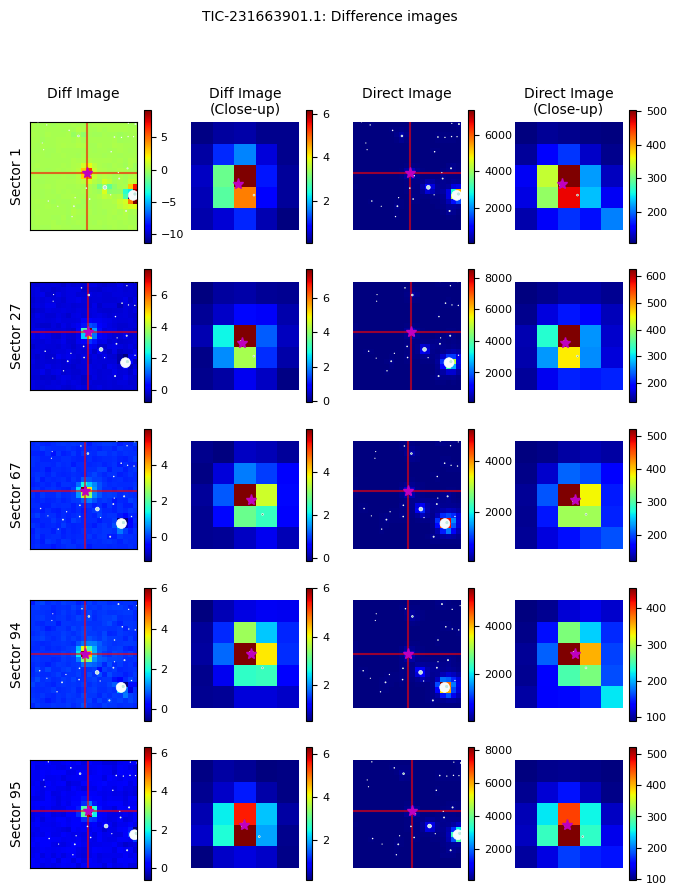

In [6]:
plot_diffimages(tlc.tic, tlc.planetno, tdi, good_sectors, good_pixel_data, save_fig=False)

This looks very nicely on-target in all sectors, as expected for a known planet! We can also now add any sector's difference image to the summary plots from before. Let's use the difference image with the best quality:

In [7]:
quality = np.array([centroid["quality"] for centroid in good_centroids])
best_quality_idx = np.argmax(quality)
best_pixel_data = good_pixel_data[best_quality_idx]
print(f"Best difference image is from Sector {good_sectors[best_quality_idx]}")

Best difference image is from Sector 95


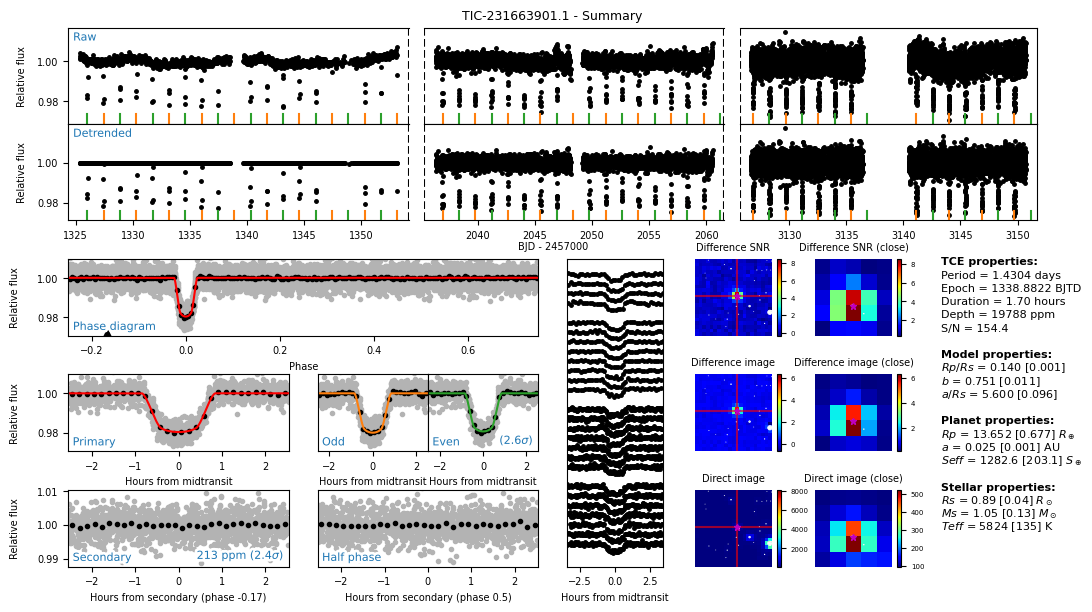

In [8]:
plot_summary_with_diff(tlc, star, tdi, best_pixel_data, save_fig=False)